In [ ]:
import numpy as np
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    GenerateHtml,
    InverseDynamicsController,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    RigidTransform,
    RollPitchYaw,
    PiecewisePolynomial,
    TrajectorySource,
    Solve,
    RotationMatrix,
    eq,
    Rgba,
    PointCloud,
)
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
from manipulation import running_as_notebook
from pydrake.multibody.tree import JacobianWrtVariable

import matplotlib.pyplot as plt 


In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://7e656c9a-e35c-4740-b249-07fef330708d.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


# Using real path

In [ ]:
def BuildAndSimulateTrajectory(q_traj, q_start, duration=0.01, time_step_def=1e-3):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    """
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step_def)
    # Note that we parse into both the plant and the scene_graph here.
    iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "file:///work/iiwa7/iiwa7_on_rail_point.sdf"
    )[0]


    print_bed = Parser(plant, scene_graph).AddModels("file:///work/cylinder.sdf")[0]

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rail"))

    bed_transform = RigidTransform()
    bed_transform.set_rotation(RollPitchYaw(0,np.pi/2,0))
    bed_transform.set_translation(np.array([1.5,-1,0.5]))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Adds an approximation of the iiwa controller.
    # TODO(russt): replace this with the joint impedance controller.
    #default: 100 1 20
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(plant, kp, ki, kd, False)
    )
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(),
        iiwa_controller.get_input_port_estimated_state(),
    )
    builder.Connect(
        iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
    )


    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))


    builder.Connect(
        q_traj_system.get_output_port(), iiwa_controller.GetInputPort("desired_state")
    )


    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.array([ 0.6,         -0.24161793,  0.1128608,   0.0,         -1.2628608,   0.7981223,
   0.37067477,  0.7197221,   0.0        ])
    x0 = np.hstack((q0, 0 * q0))
    #plant.SetPositions(plant_context, q0)
    plant.SetPositions(plant_context, q_start)


    AddMeshcatTriad(meshcat, "bed", length=0.15, radius=0.006, X_PT=bed_transform)


    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)
    visualizer.StartRecording(False)

    #SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

    #defined in bed frame
    iiwa_pos_list = []
    iiwa_world_pos_list = []
    time_list = []

    def monitor_function(context):
        plant_context = plant.GetMyContextFromRoot(context)
        iiwa_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.GetFrameByName("Build_Plate"), plant.GetFrameByName("weld_point")).translation())
        iiwa_world_pos_list.append(plant.CalcRelativeTransform(plant_context,plant.world_frame(),plant.GetFrameByName("weld_point")).translation())
        time_list.append(context.get_time())


    # Advance the simulation with the monitor
    simulator.set_monitor(monitor_function)
    simulator.AdvanceTo(duration)

    iiwa_world_pos_np = np.array(iiwa_world_pos_list)
    xyzs = np.array(iiwa_pos_list)
    #need to convert from bed frame to world frame 
    plant_context = plant.GetMyContextFromRoot(context)
    final_Bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))
    xyzs = (final_Bed_transform).multiply(xyzs.T).T

    cloud = PointCloud(len(xyzs))
    cloud.mutable_xyzs()[:] = np.transpose(xyzs)

    

    visualizer.PublishRecording()

    meshcat.SetObject("red_bunny", cloud, point_size=0.01, rgba=Rgba(1.0, 0, 0))


    return simulator, plant, time_list, iiwa_world_pos_np

In [ ]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "file:///work/iiwa7/iiwa7_on_rail_point.sdf"
    )[0]


    print_bed = Parser(plant, scene_graph).AddModels("file:///work/cylinder.sdf")[0]

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rail"))

    bed_transform = RigidTransform()
    bed_transform.set_rotation(RollPitchYaw(0,np.pi/2,0))
    bed_transform.set_translation(np.array([1.5,-1,0.5]))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)
    plant.Finalize()


    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.array([0, -1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0])
    x0 = np.hstack((q0, 0 * q0))
    plant.SetPositions(plant_context, q0)

    return plant, context, plant_context

In [ ]:
def calc_y_control_authority(plant, plant_context):    
    # Specify the gripper frame (frame_A) and world frame (frame_B)
    frame_A = plant.GetFrameByName("weld_point")
    frame_B = plant.world_frame()

    # Specify a point in the gripper frame (this could be a point on the gripper you're interested in)
    p_BoBi_B = np.array([[0], [0], [0]])

    mutable_context = plant.GetMyMutableContextFromRoot(plant_context)

    # Compute the translational velocity Jacobian with respect to v (generalized velocities)
    Jacobian_v = plant.CalcJacobianTranslationalVelocity(mutable_context, JacobianWrtVariable.kV,
                                                        frame_A, p_BoBi_B, frame_B, frame_B)

    # Print the result
    #print("Jacobian with respect to v:\n", Jacobian_v)

    control_authority_y = np.sum(np.abs(Jacobian_v[:, 1]))
    return control_authority_y

In [ ]:
plant, context, plant_context = CreateIiwaControllerPlant()
mutable_context = plant.GetMyMutableContextFromRoot(context)

q0 = np.array([0, -1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0])
x0 = np.hstack((q0, 0 * q0))
plant.SetPositions(mutable_context, q0)

print(calc_y_control_authority(plant, context))


0.4588043980223949


In [ ]:
def find_optimal_rail_pos(t_lst, weave_amplitude, weave_ang_frequency, rail_position):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    plant, context, plant_context = CreateIiwaControllerPlant()
    q_knots = []

    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("weld_point")
    q_nominal = np.array(
        [ 0.3,         -0.24161793,  0.1128608,   0.0,         -1.2628608,   0.7981223,
   0.37067477,  0.7197221,   0.0        ]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    point_list = np.zeros([3,1])
    iiwa_pos_list = []
    iiwa_world_pos_list = []

    jacob_list = []
    valid_rail_pos_list = []

    optimal_rail_pos = 0.5
    best_authority = 0
    for rail_dist_test in np.arange(0.5,1.5,0.05):
        try:
            for i in range(len(t_lst)):
                ik = inverse_kinematics.InverseKinematics(plant)
                q_variables = ik.q()  # Get variables for MathematicalProgram
                prog = ik.prog()  # Get MathematicalProgram

                #### Modify here ###############################

                ################################################


                q = ik.q()
                prog.AddQuadraticErrorCost(np.identity(len(q)), q_nominal, q)

                #locking the extra joint
                prog.AddConstraint(q[3]== 0)

                des_rot = RigidTransform()
                des_rot.set_rotation(RollPitchYaw(np.pi/2,0,np.pi/2))
                AddOrientationConstraint(ik, des_rot.rotation(), 0.01)

                bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))

                des_pos = bed_transform.translation() + np.array([-0.05,0.55,0]) + np.array([0,weave_amplitude*np.sin(t_lst[i]*weave_ang_frequency),0])

                ik.AddPositionConstraint(
                    frameA=plant.world_frame(),
                    frameB=gripper_frame,
                    p_BQ=np.zeros(3),
                    p_AQ_lower=des_pos-np.array([0.001,0.001,0.001]),
                    p_AQ_upper=des_pos+np.array([0.001,0.001,0.001]),
                )
                
                bed_des_rotation = (t_lst[i]*0.1) % 2*np.pi
                prog.AddConstraint(q[8]== bed_des_rotation)
                prog.AddConstraint(q[0]==rail_dist_test)
                

                if i == 0:
                    prog.SetInitialGuess(q, q_nominal)
                else:
                    prog.SetInitialGuess(q, last_solution)
                result = Solve(prog)

                assert result.is_success()
                last_solution = result.GetSolution(q_variables)
                q_knots.append(last_solution)

            plant.SetPositions(plant_context, last_solution)
            
            iiwa_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.GetFrameByName("Build_Plate"), plant.GetFrameByName("weld_point")).translation())
            iiwa_world_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("weld_point")).translation())
            mutable_context = plant.GetMyMutableContextFromRoot(context)

            plant.SetPositions(mutable_context, last_solution)

            this_y_auth = calc_y_control_authority(plant, context)
            if this_y_auth > best_authority:
                optimal_rail_pos = rail_dist_test
                best_authority = this_y_auth

            jacob_list.append(this_y_auth)
            valid_rail_pos_list.append(rail_dist_test)
        except:
            print("invalid position: " + str(rail_dist_test))

    # plotting
    plt.title("Effect of Rail Position on Y Control Authority from Jacobian")
    plt.xlabel("Rail position (m)") 
    plt.ylabel("Y Control Authority from Jacobian") 


    print(jacob_list)
    print(valid_rail_pos_list)

    plt.plot(valid_rail_pos_list, jacob_list, color ="red") 
    plt.show()

    return optimal_rail_pos

In [ ]:
def create_q_knots(t_lst, weave_amplitude, weave_ang_frequency, rail_position):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, context, plant_context = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("weld_point")
    q_nominal = np.array(
        [ 0.3,         -0.24161793,  0.1128608,   0.0,         -1.2628608,   0.7981223,
   0.37067477,  0.7197221,   0.0        ]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    point_list = np.zeros([3,1])
    iiwa_pos_list = []
    iiwa_world_pos_list = []

    for i in range(len(t_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        ################################################


        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q_nominal, q)

        #locking the extra joint
        prog.AddConstraint(q[3]== 0)

        des_rot = RigidTransform()
        des_rot.set_rotation(RollPitchYaw(np.pi/2,0,np.pi/2))
        AddOrientationConstraint(ik, des_rot.rotation(), 0.01)


        bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))

        des_pos = bed_transform.translation() + np.array([-0.05,0.55,0]) + np.array([0,weave_amplitude*np.sin(t_lst[i]*weave_ang_frequency),0])

        
        ik.AddPositionConstraint(
            frameA=plant.world_frame(),
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=des_pos-np.array([0.001,0.001,0.001]),
            p_AQ_upper=des_pos+np.array([0.001,0.001,0.001]),
        )
        
        bed_des_rotation = (t_lst[i]*0.1) % 2*np.pi
        prog.AddConstraint(q[8]== bed_des_rotation)
        prog.AddConstraint(q[0]==rail_position)
        

        if i == 0:
            prog.SetInitialGuess(q, q_nominal)
        else:
            prog.SetInitialGuess(q, last_solution)
        result = Solve(prog)

        assert result.is_success()
        last_solution = result.GetSolution(q_variables)
        q_knots.append(last_solution)

        plant.SetPositions(plant_context, last_solution)
        iiwa_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.GetFrameByName("Build_Plate"), plant.GetFrameByName("weld_point")).translation())
        iiwa_world_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("weld_point")).translation())
        

    xyzs = np.array(iiwa_pos_list)
    final_Bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))
    xyzs = (final_Bed_transform).multiply(xyzs.T).T

    cloud = PointCloud(len(xyzs))
    cloud.mutable_xyzs()[:] = np.transpose(xyzs)

    meshcat.SetObject("blue_bunny", cloud, point_size=0.01, rgba=Rgba(0, 0, 1.0))


    return q_knots, np.array(iiwa_world_pos_list)

In [ ]:
def calculate_amplitude_difference(desired_path, actual_path, desired_times, actual_times):

    return abs(min(actual_path)) / abs(min(desired_path))



In [ ]:
def helper_find_best_rail_pos(rail_pos, weave_ang_freq, weave_amp):
    meshcat.Delete("blue_bunny")
    meshcat.Delete("red_bunny")

    num_periods = 30

    time_step_def = 1e-3

    sim_time = (2*np.pi/weave_ang_freq)*num_periods
    frames_per_sec = weave_ang_freq*4
    t_lst = np.linspace(0, sim_time, int(sim_time*frames_per_sec))
    return find_optimal_rail_pos(t_lst, weave_amp, weave_ang_freq, rail_pos)

In [ ]:
def simulate_weave(rail_pos, weave_ang_freq, weave_amp):
    meshcat.Delete("blue_bunny")
    meshcat.Delete("red_bunny")

    num_periods = 5

    time_step_def = 1e-3

    sim_time = (2*np.pi/weave_ang_freq)*num_periods
    frames_per_sec = weave_ang_freq*4
    t_lst = np.linspace(0, sim_time, int(sim_time*frames_per_sec))

    

    q_knot_output, iiwa_des_pos_world = create_q_knots(t_lst, weave_amp,weave_ang_freq, rail_pos)

    q_knots = np.array(q_knot_output)

    double_q_knots = np.hstack((q_knots, q_knots*0))

    q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, double_q_knots[:, 0:18].T)

    simulator, station_plant, sim_time_list, sim_iiwa_pos = BuildAndSimulateTrajectory(q_traj, q_knots[0], sim_time)
    

    
    
    # plotting
    #plt.title("Graph for " + str(rail_pos) + "m Rail Position")
    plt.xlabel("Time (s)") 
    plt.ylabel("Weave Axis Position (m)") 

    iiwa_des_y_centered = iiwa_des_pos_world[:,1] - iiwa_des_pos_world[0,1]
    iiwa_sim_y_centered = sim_iiwa_pos[:,1] - sim_iiwa_pos[0,1]
    
    plt.plot(t_lst, iiwa_des_y_centered, color ="blue", label="Desired Weave Trajectory")
    plt.plot(sim_time_list, iiwa_sim_y_centered, color ="red", label="Simulated Weave Trajectory") 
    plt.legend(loc="upper left")
    plt.show()
    


    print("Ratio of simulated amplitude to desired amplitude: ")
    amplitude_ratio = calculate_amplitude_difference(iiwa_des_y_centered, iiwa_sim_y_centered, t_lst, sim_time_list)
    print(amplitude_ratio)
    return amplitude_ratio

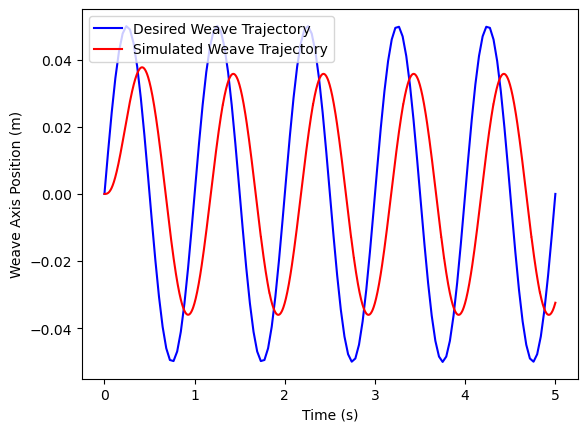

Ratio of simulated amplitude to desired amplitude: 
0.719731212519274


0.719731212519274

In [ ]:
simulate_weave(1.2, 2*np.pi, 0.05)

# Changing Rail pos across different frequencies

invalid position: 0.5
invalid position: 0.55
invalid position: 0.6000000000000001
invalid position: 0.6500000000000001
invalid position: 0.7000000000000002
invalid position: 1.2500000000000007
invalid position: 1.3000000000000007
invalid position: 1.3500000000000008
invalid position: 1.4000000000000008
0.7500000000000002
Ratio of simulated amplitude to desired amplitude: 
0.7358511797192968
Ratio of simulated amplitude to desired amplitude: 
0.9178272336008372
Ratio of simulated amplitude to desired amplitude: 
0.9139932958033998
Ratio of simulated amplitude to desired amplitude: 
0.9118689800630524
Ratio of simulated amplitude to desired amplitude: 
0.9119173122844023
Ratio of simulated amplitude to desired amplitude: 
0.9121240659340001
[0.75 0.85 0.95 1.05 1.15]
[0.9178272336008372, 0.9139932958033998, 0.9118689800630524, 0.9119173122844023, 0.9121240659340001]
invalid position: 0.5
invalid position: 0.55
invalid position: 0.6000000000000001
invalid position: 0.6500000000000001
inva

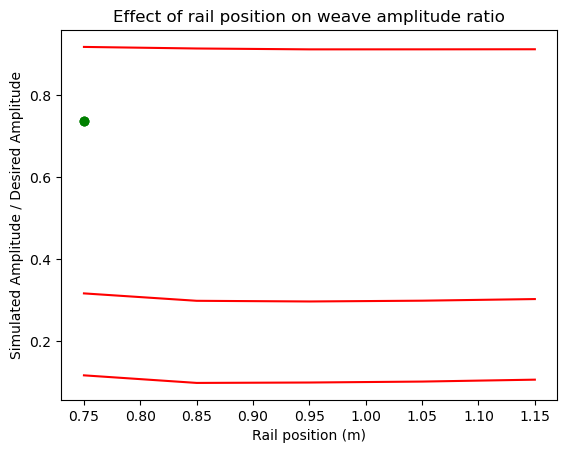

In [ ]:
freq_test_vals = [np.pi, np.pi*5, np.pi*10]


for freq_val_test in freq_test_vals:
    rail_pos_vals = np.arange(0.75,1.2,0.1)
    amplitude_list = []

    best_pos = helper_find_best_rail_pos(0, 2*np.pi, 0.1)
    print(best_pos)

    best_pos_amp = simulate_weave(best_pos, 2*np.pi, 0.1)


    for rail_pos_val in rail_pos_vals:
        try:
            this_amplitude = simulate_weave(rail_pos_val, freq_val_test, 0.1)
            amplitude_list.append(this_amplitude)
        except:
            print("ope " + str(rail_pos_val))


    # plotting
    plt.title("Effect of rail position on weave amplitude ratio")
    plt.xlabel("Rail position (m)") 
    plt.ylabel("Simulated Amplitude / Desired Amplitude") 


    print(rail_pos_vals)
    print(amplitude_list)

    plt.plot(best_pos, best_pos_amp, 'go')
    plt.plot(rail_pos_vals, amplitude_list, color ="red") 

plt.show()

# Changing rail pos

invalid position: 0.5
invalid position: 0.55
invalid position: 0.6000000000000001
invalid position: 0.6500000000000001
invalid position: 0.7000000000000002
invalid position: 1.2500000000000007
invalid position: 1.3000000000000007
invalid position: 1.3500000000000008
invalid position: 1.4000000000000008
[1.1519999999997381, 1.1019999999983514, 1.0519999999990792, 1.0019999999845195, 0.9519999999903359, 0.9019999999983356, 0.8519999999612404, 0.8019999999995344, 0.7519999999997687, 0.7019999999998008, 0.45199999999926566]
[0.7500000000000002, 0.8000000000000003, 0.8500000000000003, 0.9000000000000004, 0.9500000000000004, 1.0000000000000004, 1.0500000000000005, 1.1000000000000005, 1.1500000000000006, 1.2000000000000006, 1.4500000000000008]


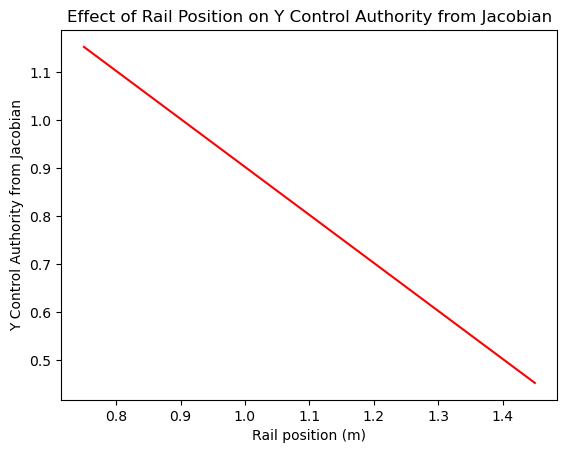

0.7500000000000002
Ratio of simulated amplitude to desired amplitude: 
0.1160368052545785
Ratio of simulated amplitude to desired amplitude: 
0.11603680525457831
Ratio of simulated amplitude to desired amplitude: 
0.09952566897933277
Ratio of simulated amplitude to desired amplitude: 
0.09753247116652436
Ratio of simulated amplitude to desired amplitude: 
0.09876288878295399
Ratio of simulated amplitude to desired amplitude: 
0.09852141420954315
Ratio of simulated amplitude to desired amplitude: 
0.09928061892933335
Ratio of simulated amplitude to desired amplitude: 
0.10082851600864685
Ratio of simulated amplitude to desired amplitude: 
0.10298470943730798
Ratio of simulated amplitude to desired amplitude: 
0.10549212248174722
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15]
[0.11603680525457831, 0.09952566897933277, 0.09753247116652436, 0.09876288878295399, 0.09852141420954315, 0.09928061892933335, 0.10082851600864685, 0.10298470943730798, 0.10549212248174722]


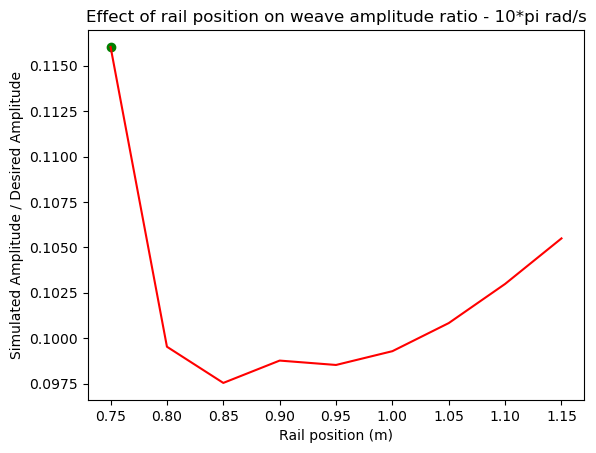

In [ ]:
rail_pos_vals = np.arange(0.75,1.2,0.05)
amplitude_list = []

this_freq = 10*np.pi

best_pos = helper_find_best_rail_pos(0, this_freq, 0.1)
print(best_pos)

best_pos_amp = simulate_weave(best_pos, this_freq, 0.1)


for rail_pos_val in rail_pos_vals:
    try:
        this_amplitude = simulate_weave(rail_pos_val, this_freq, 0.1)
        amplitude_list.append(this_amplitude)
    except:
        print("ope " + str(rail_pos_val))


# plotting
plt.title("Effect of rail position on weave amplitude ratio - 10*pi rad/s")
plt.xlabel("Rail position (m)") 
plt.ylabel("Simulated Amplitude / Desired Amplitude") 


print(rail_pos_vals)
print(amplitude_list)

plt.plot(best_pos, best_pos_amp, 'go')
plt.plot(rail_pos_vals, amplitude_list, color ="red") 
plt.show(best_pos, best_pos_amp)

# Varying Weave Amplitude - freq 4pi

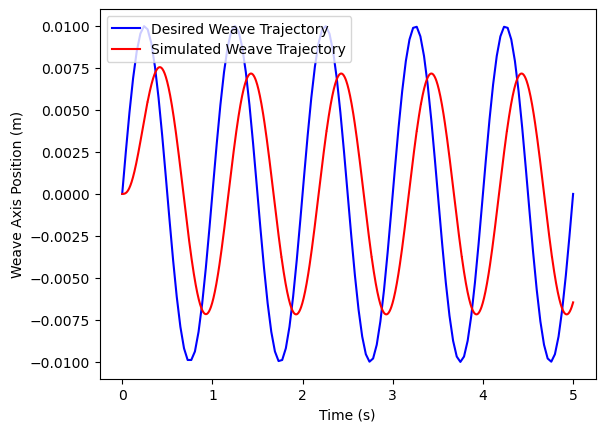

Ratio of simulated amplitude to desired amplitude: 
0.7169663433003508


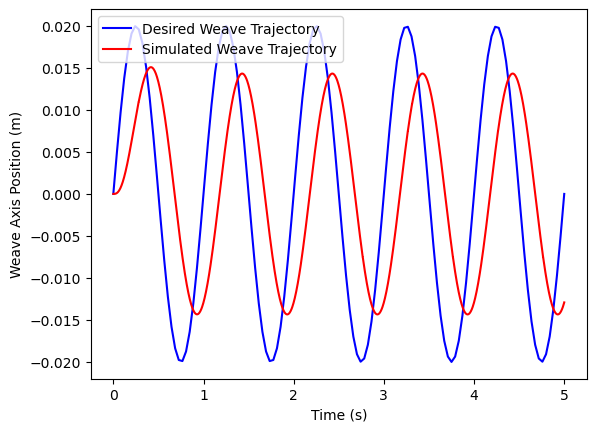

Ratio of simulated amplitude to desired amplitude: 
0.7172354821999893


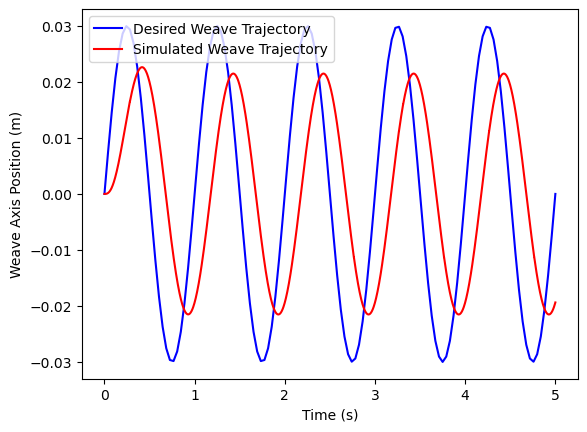

Ratio of simulated amplitude to desired amplitude: 
0.7175486529681763


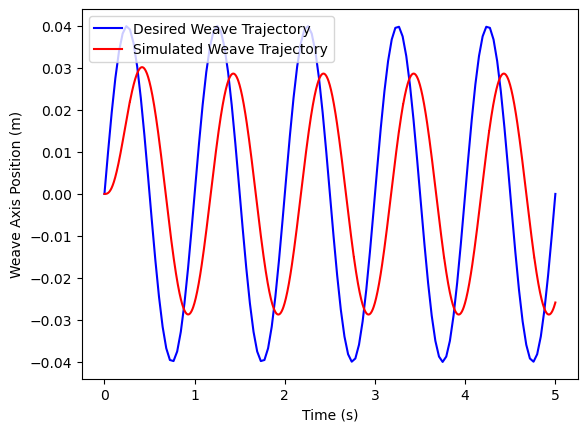

Ratio of simulated amplitude to desired amplitude: 
0.7179075916545983


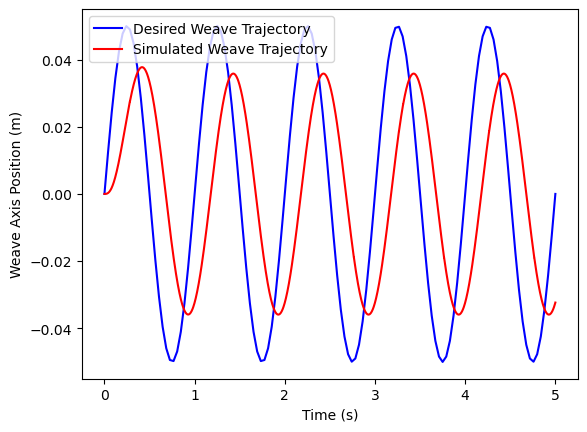

Ratio of simulated amplitude to desired amplitude: 
0.7183143067798152


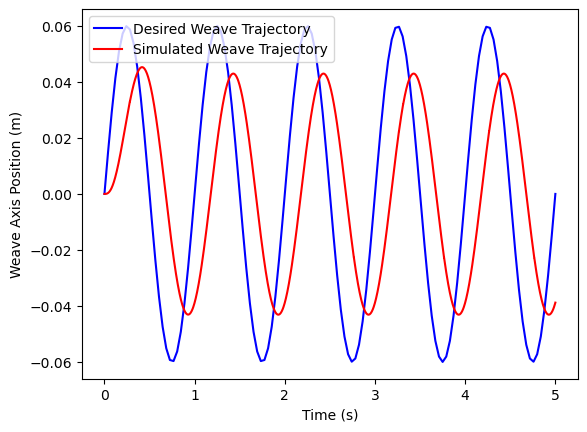

Ratio of simulated amplitude to desired amplitude: 
0.7187711769490083


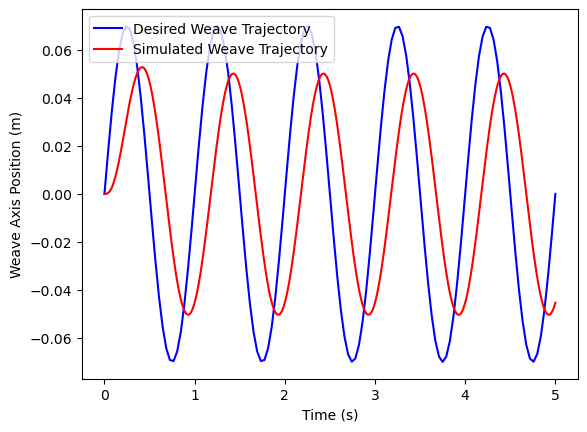

Ratio of simulated amplitude to desired amplitude: 
0.7192809614920121


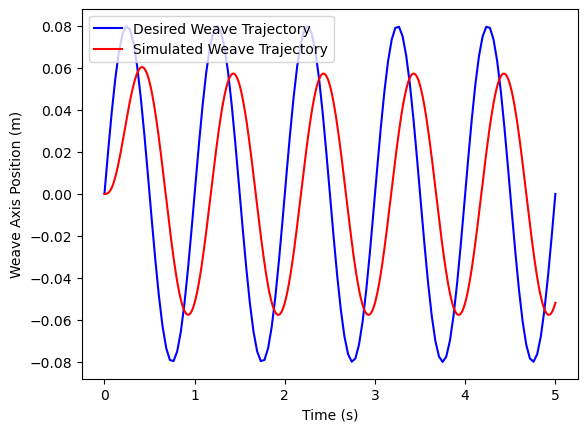

Ratio of simulated amplitude to desired amplitude: 
0.7198469198186082


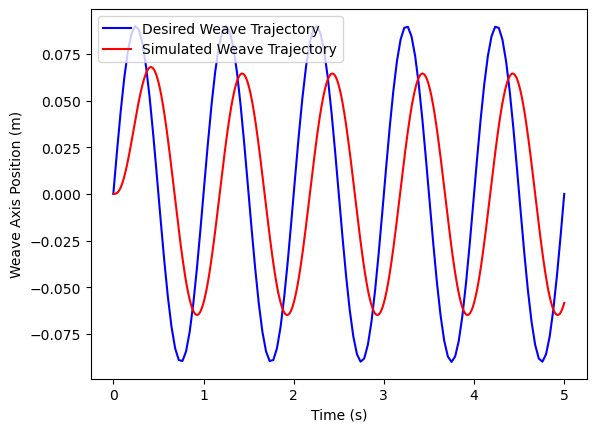

Ratio of simulated amplitude to desired amplitude: 
0.7204728844269827
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]
[0.7169663433003508, 0.7172354821999893, 0.7175486529681763, 0.7179075916545983, 0.7183143067798152, 0.7187711769490083, 0.7192809614920121, 0.7198469198186082, 0.7204728844269827]


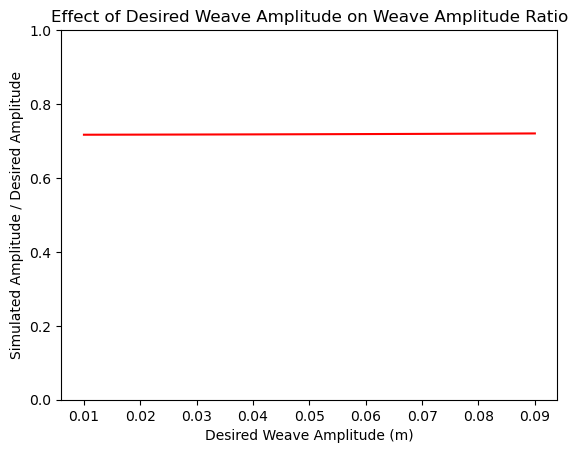

In [ ]:
amplitude_vals_test = np.arange(0.01, 0.1, 0.01)
amplitude_list = []

#best_pos = helper_find_best_rail_pos(0, 2*np.pi*2, 0.1)
#print(best_pos)

#best_pos_amp = simulate_weave(best_pos, 2*np.pi*2, 0.1)


for amplitude_val in amplitude_vals_test:
    try:
        this_amplitude = simulate_weave(1.0, 2*np.pi, amplitude_val)
        amplitude_list.append(this_amplitude)
    except:
        print("ope " )


# plotting
plt.title("Effect of Desired Weave Amplitude on Weave Amplitude Ratio")
plt.xlabel("Desired Weave Amplitude (m)") 
plt.ylabel("Simulated Amplitude / Desired Amplitude") 

print(amplitude_vals_test)
print(amplitude_list)

#plt.plot(best_pos, best_pos_amp, 'ro')
plt.plot(amplitude_vals_test, amplitude_list, color ="red") 
plt.ylim([0,1])
plt.show()
#plt.show(best_pos, best_pos_amp)

# Varying weave frequency - rail 1.0m

3.141592653589793


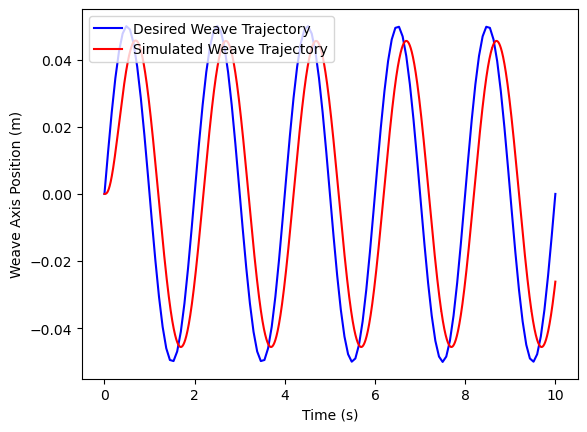

Ratio of simulated amplitude to desired amplitude: 
0.9111195780278827
6.283185307179586


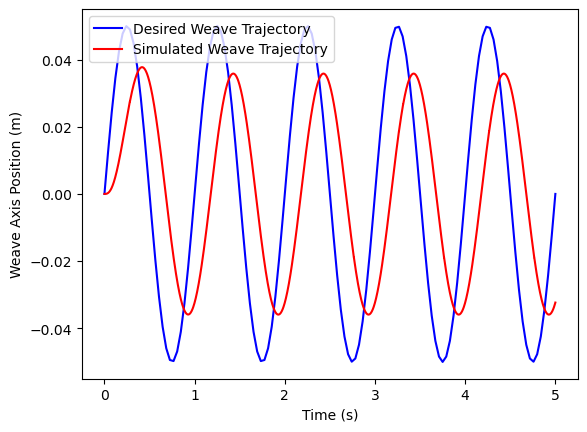

Ratio of simulated amplitude to desired amplitude: 
0.7183143067798152
9.42477796076938


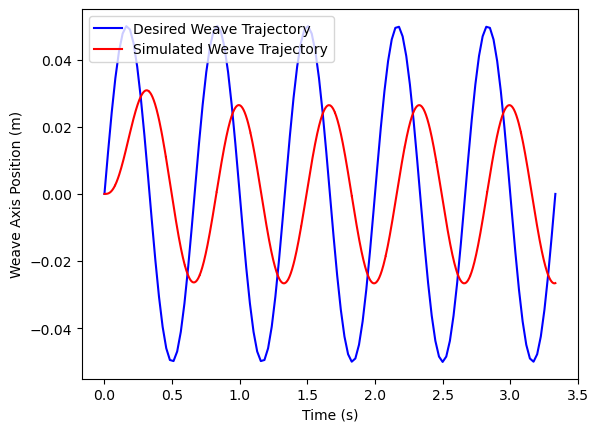

Ratio of simulated amplitude to desired amplitude: 
0.5322233802954255
12.566370614359172


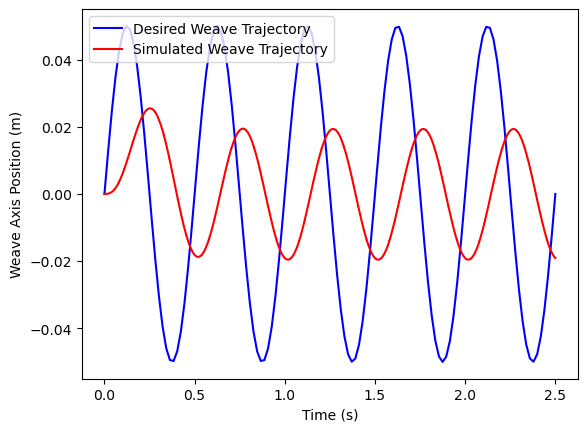

Ratio of simulated amplitude to desired amplitude: 
0.391340271576596
15.707963267948966


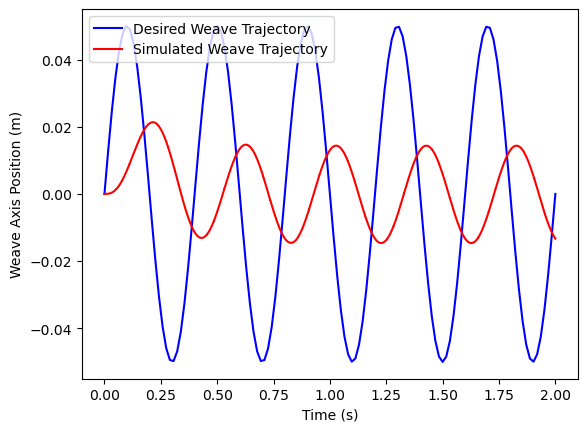

Ratio of simulated amplitude to desired amplitude: 
0.29249545572386704
18.84955592153876


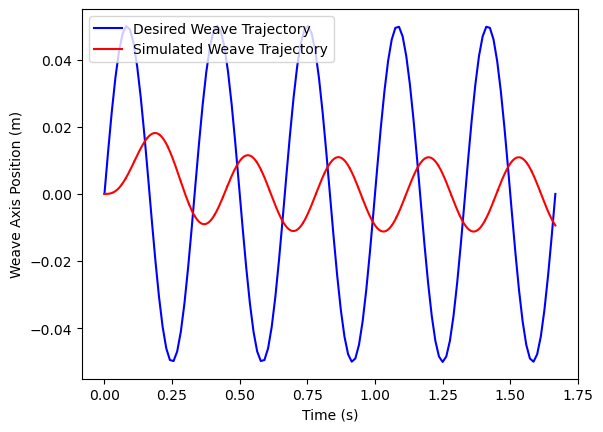

Ratio of simulated amplitude to desired amplitude: 
0.22386754702582712
21.991148575128552


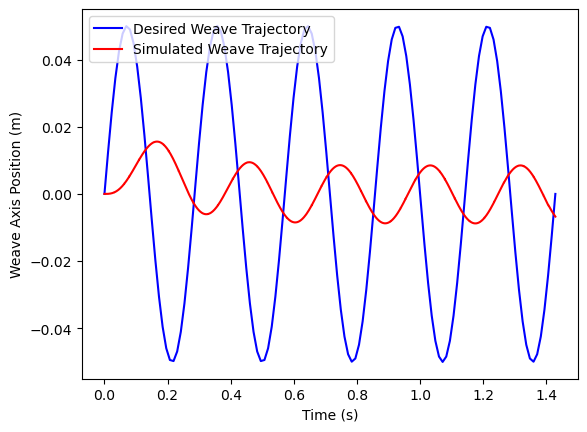

Ratio of simulated amplitude to desired amplitude: 
0.1755496814225172
25.132741228718345


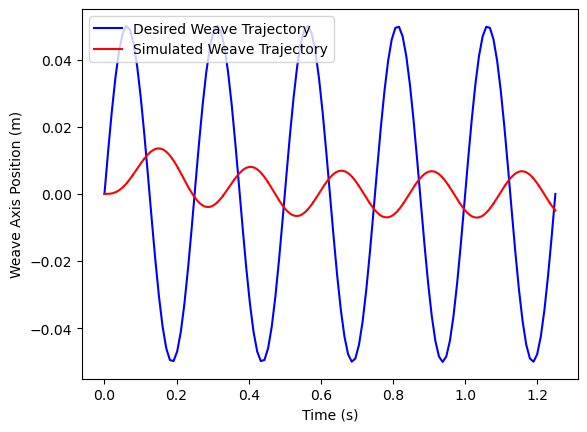

Ratio of simulated amplitude to desired amplitude: 
0.14071402203646521
28.274333882308138


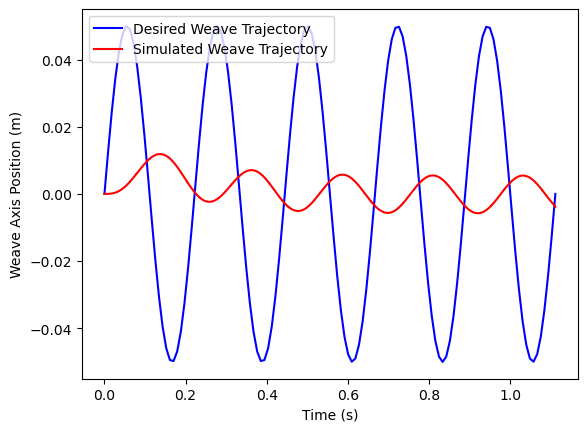

Ratio of simulated amplitude to desired amplitude: 
0.11493121173945253
[ 3.14159265  6.28318531  9.42477796 12.56637061 15.70796327 18.84955592
 21.99114858 25.13274123 28.27433388]
[0.9111195780278827, 0.7183143067798152, 0.5322233802954255, 0.391340271576596, 0.29249545572386704, 0.22386754702582712, 0.1755496814225172, 0.14071402203646521, 0.11493121173945253]


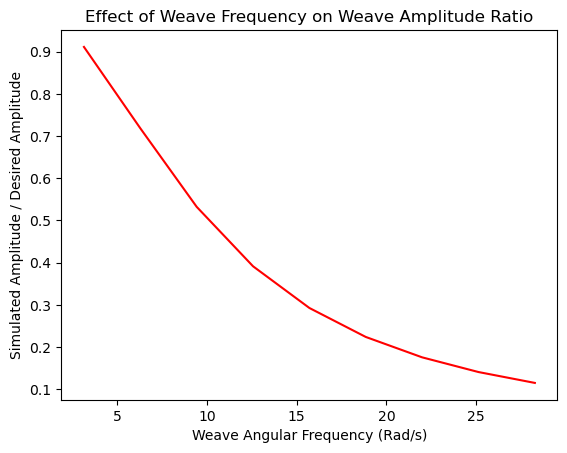

In [ ]:
freq_vals_test = np.arange(np.pi, 10*np.pi, np.pi)
amplitude_list = []

#best_pos = helper_find_best_rail_pos(0, 2*np.pi*2, 0.1)
#print(best_pos)

#best_pos_amp = simulate_weave(best_pos, 2*np.pi*2, 0.1)


for freq_val in freq_vals_test:
    print(freq_val)
    try:
        this_amplitude = simulate_weave(1.0, freq_val, 0.05)
        amplitude_list.append(this_amplitude)
    except:
        print("ope " )


# plotting
plt.title("Effect of Weave Frequency on Weave Amplitude Ratio")
plt.xlabel("Weave Angular Frequency (Rad/s)") 
plt.ylabel("Simulated Amplitude / Desired Amplitude") 

print(freq_vals_test)
print(amplitude_list)

#plt.plot(best_pos, best_pos_amp, 'ro')
plt.plot(freq_vals_test, amplitude_list, color ="red") 
plt.show()
#plt.show(best_pos, best_pos_amp)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7e656c9a-e35c-4740-b249-07fef330708d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>